In [1]:
import torch
from torch import nn
import torch.functional as F
from torch.utils.data import random_split, DataLoader


import pandas as pd
import scanpy as sc
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import lightning.pytorch as pl

from pytorch_lightning.loggers import WandbLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint
import wandb

import networkx as nx

In [1209]:
class ObsDataset(pl.LightningDataModule):
    def __init__(self, file, batch_size=2048, num_workers=10, train_split=0.9, toy=False, normalize=False):

        super().__init__()
        
        self.file = file
        self.batch_size = batch_size
        self.train_split = train_split
        self.num_workers = num_workers
        self.toy = toy
        self.normalize = normalize
        
        self._load_data()
        
        self.n_genes = len(self.adata.var)
        self.n_cells = len(self.adata.obs)
        
    def _load_data(self):
        self.adata = sc.read_h5ad(self.file)
        if self.toy:
            self._make_toy_dataset()
        self.genes = np.array(self.adata.var.gene_name)
            
    def _make_toy_dataset(self):
        sc.pp.subsample(self.adata, n_obs=10000)
        self._load_interaction_datasets()
        
        self.prepare_data(self.normalize)
        
        self.adata = self.adata[:, self.adata.var.gene_name.isin(self.selected_genes)]
        
    def prepare_data(self, normalize=False):
        
        #max_val = np.apply_along_axis(lambda x: np.percentile(x, 0.99), 0, self.adata.X)
        #for i in range(self.n_genes):
        #    self.adata.X[self.adata.X[:, i] > max_val[i], i] = max_val[i]
            
        if normalize:
            sc.pp.normalize_per_cell(self.adata, key_n_counts='UMI_count')
            sc.pp.log1p(self.adata)  
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            train_size = int(self.n_cells * self.train_split)
            val_size = self.n_cells - int(self.n_cells * self.train_split)
            self.train, self.val = random_split(self.adata.X.toarray(), [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=False)
    
    def _load_interaction_datasets(self, n_genes=500):
    
        np.random.seed(0)

        eval_dir = '/home/artemy/causal_proj/data/competition_data/eval_metrics/'
        chip_data = pd.read_csv(eval_dir + 'K562_ChipSeq.csv', index_col=0)

        self.regulator = 'BDP1'
        self.regulon = chip_data.loc[chip_data['source'] == self.regulator, 'target']
        self.regulon = self.regulon[self.regulon.isin(self.adata.var.gene_name)].tolist()

        genes_not_in_regulon = self.adata.var.gene_name[~self.adata.var.gene_name.isin(self.regulon + [self.regulator])].tolist()
        additional_genes = np.random.choice(genes_not_in_regulon, 500-len(self.regulon) - 1, replace=False).tolist()

        self.additional_genes = additional_genes
        self.selected_genes = [self.regulator] + self.regulon + additional_genes


        protein_info = pd.read_csv(eval_dir + 'protein.info.txt.gz', sep='\t')
        ensp2gs = dict(zip(protein_info.iloc[:, 0], protein_info.iloc[:, 1]))

        protein_links = pd.read_csv(eval_dir + 'protein.links.txt.gz', sep=' ')
        protein_links['protein1'] = protein_links['protein1'].apply(lambda x: ensp2gs[x])
        protein_links['protein2'] = protein_links['protein2'].apply(lambda x: ensp2gs[x])
        self.protein_links = protein_links[protein_links['protein1'].isin(self.selected_genes) \
                                                   & protein_links['protein2'].isin(self.selected_genes)]



In [3]:
from sklearn.metrics import auc

class ToyEvaluator:
    def __init__(self, dataset):
        self.dataset = dataset
        self.genes = self.dataset.genes
        self.protein_links = self.dataset.protein_links
        self.regulon = self.dataset.regulon
        self.regulator = self.dataset.regulator
        self.additional_genes = self.dataset.additional_genes
        
    def evaluate_adj_matrix(self, Adj, verbose=True):
        Adj = pd.DataFrame(Adj, index=self.genes, columns=self.genes)
        self._describe_adj(Adj, verbose)
        thresholds = self._calculate_thresholds(Adj)
        metrics = self._calculate_metrics(Adj, thresholds, verbose)
        metrics['Max value'] = Adj.values.max()
        return metrics
        
        
    def _describe_adj(self, Adj, verbose):
        if verbose:
            shape = Adj.shape
            print('Input shape: %s*%s' % (shape[0], shape[1]))
            number_of_zeros = (Adj < 1e-3).values.sum()
            print('Number of zeros: %s' % (number_of_zeros))
            max_val = Adj.values.max()
            min_val = Adj.values.min()
            print('Max val: %s\nMin val: %s' % (max_val, min_val))
            plt.hist(Adj.values.flatten())
            plt.title('Score distribution')
            plt.show()
        
    def _calculate_thresholds(self, Adj):
        thresholds = np.concatenate((np.arange(0, 0.01, 0.001), 
                                                  (0.01, 0.02, 0.03)))
        
        
        return thresholds
    
    def _calculate_metrics(self, Adj, thresholds, verbose):
        tp = np.zeros_like(thresholds)
        tn = np.zeros_like(thresholds)
        fp = np.zeros_like(thresholds)
        fn = np.zeros_like(thresholds)
        
        regulator_links = np.zeros_like(thresholds)
        regulon_links = np.zeros_like(thresholds)
        outside_regulon_links = np.zeros_like(thresholds)
        
        num_comps = np.zeros_like(thresholds)
        clustering_coef = np.zeros_like(thresholds)
        graph_diameter = np.zeros_like(thresholds)
        giant_component = np.zeros_like(thresholds)
        
        for i, t in enumerate(thresholds):
            hard_Adj = Adj >= t
            
            hard_Adj = hard_Adj + hard_Adj.T
            
            tp[i], tn[i], fp[i], fn[i] = self._analyze_protein_links(hard_Adj)
            regulator_links[i], regulon_links[i], outside_regulon_links[i] = self._analyze_regulon(hard_Adj)
            num_comps[i], clustering_coef[i], graph_diameter[i], giant_component[i] = self._evaluate_graph_properties(hard_Adj)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        precision[tp + fp == 0] = 0
                    
        metrics = {}
        metrics['String PR AUC'] = auc(recall, precision)
        metrics['Chip AUC'] = auc(regulator_links, regulon_links)
        
        for num, i in enumerate([3, 6, 11]):
            t = thresholds[i]
            thresh = f'Threshold num {num+1}/'
            
            
            metrics[f'{thresh}String recall'] = recall[i]
            metrics[f'{thresh}String precision'] = precision[i]
            metrics[f'{thresh}String TP'] = tp[i]
            
            metrics[f'{thresh}Chip links with regulator'] = regulator_links[i] * 100
            metrics[f'{thresh}String links within regulon'] = regulon_links[i] * 100
            metrics[f'{thresh}String links outside of regulon'] = outside_regulon_links[i] * 100
            
            metrics[f'{thresh}Num of components'] = num_comps[i]
            metrics[f'{thresh}Largest component'] = giant_component[i]
            metrics[f'{thresh}Graph diameter'] = graph_diameter[i]
            metrics[f'{thresh}Clustering coefficient'] = clustering_coef[i]

            
        if verbose:
            self._make_plots(thresholds, precision, recall, regulator_links, regulon_links)
        return metrics
        
    def _evaluate_graph_properties(self, Adj):
        G = nx.from_numpy_array(Adj.values)
        num_comps = nx.number_connected_components(G)
        clustering_coef = nx.average_clustering(G)
        giant_component = sorted(nx.connected_components(G), key=len, reverse=True)[0]
        giant_component_size = len(giant_component)
        graph_diameter = nx.diameter(G.subgraph(giant_component))
        #degree_distribution = [d for n, d in G.degree()]
        return num_comps, clustering_coef, graph_diameter, giant_component_size
            
    def _analyze_protein_links(self, Adj):
        tp = 0
        
        for i in range(len(self.protein_links)):
            interaction = self.protein_links.iloc[i, [0, 1]]
            tp += Adj.loc[interaction[0], interaction[1]]
        fp = Adj.values.sum() - tp
        fn = len(self.protein_links) - tp
        
        tn = Adj.shape[0] ** 2 - len(self.protein_links) - fp
        
        return tp, tn, fp, fn
    
    def _analyze_regulon(self, Adj):
        regulator_links = Adj.loc[self.regulator, self.regulon].values.sum()
        regulator_links /= len(self.regulon) 
        
        regulon_links = Adj.loc[self.regulon, self.regulon].values.sum()
        regulon_links /= len(self.regulon) ** 2
        
        outside_regulon_links = Adj.loc[~Adj.index.isin([self.regulator]), ~Adj.columns.isin([self.regulator])].values.sum()
        outside_regulon_links -= Adj.loc[self.regulon, self.regulon].values.sum()
        outside_regulon_links -= Adj.loc[self.additional_genes, self.additional_genes].values.sum()
        outside_regulon_links /= (len(self.additional_genes) + len(self.regulon)) ** 2 - len(self.additional_genes) ** 2 - len(self.regulon) ** 2
        
        return regulator_links, regulon_links, outside_regulon_links
    
    def _make_plots(self, thresholds, precision, recall, regulator_links, regulon_links):
        
        
        plt.scatter(recall, precision, c=thresholds)
        plt.colorbar(label='thresholds')
        plt.title('PR curve. AUC:%.3f' % auc(recall, precision))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        
        plt.scatter(regulon_links, regulator_links, c=thresholds)
        plt.colorbar(label='thresholds')
        plt.title('Regulon interactions. AUC:%.3f' % auc(regulator_links, regulon_links))
        plt.xlabel('Within regulon links')
        plt.ylabel('Links to regulator')
        plt.show()

In [4]:
class EvaluatorCallback(Callback):
    def __init__(self, evaluator):
        super().__init__()
        self.evaluator = evaluator
    
    def on_train_epoch_end(self, trainer, model):
        model.calculate_attention_matrix()
        metrics = self.evaluator.evaluate_adj_matrix(model.attention_matrix, verbose=False)
        for item in metrics:
            model.log(item, metrics[item])
        

In [822]:
def init_weights(m, activation='relu'):
    if isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    
    if activation == 'silu':
        if isinstance(m, nn.Conv1d):
            n = m.kernel_size[0] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2 / n))
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.001)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0) 
        elif isinstance(m, nn.Embedding):
            m.weight.data.normal_(0, 0.001)
          
    else:
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            m.bias.data.fill_(0.01) 
        elif isinstance(m, nn.Embedding):
            torch.nn.init.kaiming_uniform_(m.weight)

In [823]:
class BinaryAttention(nn.Module):
    def __init__(self, input_dim, function='sigmoid'):
        super().__init__()
        self.ll_keys = nn.Linear(input_dim, input_dim)
        self.ll_queries = nn.Linear(input_dim, input_dim)
        #self.ll_values = nn.Linear(input_dim, input_dim)
        
        if function == 'sigmoid':
            self.func = torch.sigmoid
        elif function == 'tanh':
            self.func = torch.tanh
        elif function == 'softmax':
            self.func = lambda x: torch.softmax(x, -1)
        elif function == 'softmax_t':
            self.func = lambda x: torch.softmax(x, -2)
                    
    def forward(self, x, y, hidden_idxs=None):
        x = self.ll_keys(x)
        y = self.ll_keys(y)
        
        if x.dim() == 3:
            att = torch.einsum('btk, blk -> btl', x, y)  
        elif x.dim() == 2:
            att = torch.einsum('tk, lk -> tl', x, y)
        
         

        if hidden_idxs is not None:
            hidden_matrix = torch.ones_like(att)
            hidden_matrix[:, hidden_idxs] = 0
            att = att * hidden_matrix
            
        diag_matrix = torch.ones_like(att)
        diag_idxs = range(att.shape[0])
        diag_matrix[diag_idxs, diag_idxs] = 0
        att = att * diag_matrix
        
        
        #
#         att = torch.where(att >= att.quantile(0.85, 0), att, 0) 
        att = torch.where(att != 0, att, -torch.inf)
        
        att = self.func(att)
        
        
        #att = torch.where(att > 0.02, 1, 0).float()
        
        
        
#         att = torch.where(att >= att.quantile(0.95, 1)[:, None], 1, 0)
        
#         att = att / att.sum(1)[:, None]
        
        return att 

In [1073]:
class BatchNormEmbed(nn.Module):
    def __init__(self, input_size, embed_size):
        super().__init__()
    
        self.input_size = input_size
        self.embed_size = embed_size
        self.bn = nn.BatchNorm1d(self.input_size * self.embed_size)
        
    def forward(self, x):
        shape = x.shape
        x = torch.flatten(x, 1)
        x = self.bn(x)
        x = x.reshape(shape)
        return x


class AttBlock(nn.Module):
    def __init__(self, input_size, embed_size):
        super().__init__()
    
        self.input_size = input_size
        self.embed_size = embed_size
        
        self.act = nn.ReLU()
        self.ll1 = nn.Linear(self.embed_size, self.embed_size)
        self.bn_attn1 = BatchNormEmbed(self.input_size, self.embed_size)
        self.bn1 = BatchNormEmbed(self.input_size, self.embed_size)
        
    def forward(self, x, attn_weights):
    
        attn_output1 = torch.einsum('bjk, lj -> blk', x, attn_weights)
        attn_output1 = attn_output1 + x
        attn_output1 = attn_output1.permute(0, 2, 1)
        attn_output1 = self.bn_attn1(attn_output1)
        attn_output1 = attn_output1.permute(0, 2, 1)

        ll_output1 = self.ll1(attn_output1)
        ll_output1 = attn_output1 + ll_output1
        ll_output1 = ll_output1.permute(0, 2, 1)
        ll_output1 = self.bn1(ll_output1)
        ll_output1 = ll_output1.permute(0, 2, 1)
        ll_output1 = self.act(ll_output1)
        
        return ll_output1

In [1167]:
class Model(pl.LightningModule):
    def __init__(self, genes, n_genes_in_minibatch, 
                     embed_size=10, lr=0.001, perc_hidden=0.25, wd=0.01):
        super().__init__()
        self.genes = genes
        self.n_genes = len(self.genes)
        self.n_genes_in_minibatch = n_genes_in_minibatch
        self.embed_size = embed_size
        self.lr = lr
        self.wd = wd
        self.perc_hidden = perc_hidden
        self.calculate_attention = True
        
        self.act = nn.LeakyReLU(0.2)
        self.embedding = nn.Embedding(self.n_genes, embed_size)
        self.ll0 = nn.Linear(self.embed_size+1, self.embed_size+1)
        self.attn = BinaryAttention(self.embed_size, function='softmax')
       
        self.att_block1 = AttBlock(self.n_genes_in_minibatch, self.embed_size+1)
        self.att_block2 = AttBlock(self.n_genes_in_minibatch, self.embed_size+1)
        self.att_block3 = AttBlock(self.n_genes_in_minibatch, self.embed_size+1)
        self.att_block4 = AttBlock(self.n_genes_in_minibatch, self.embed_size+1)
        
#         self.bn_attn3 = nn.BatchNorm1d(self.embed_size)
#         self.ll3 = nn.Linear(self.embed_size, self.embed_size)
#         self.bn3 = nn.BatchNorm1d(self.embed_size)
        self.ll_prefin = nn.Linear(self.embed_size+1, self.embed_size+1)
        self.ll_fin = nn.Linear(self.embed_size+1, 1)
        
        self.model = nn.ModuleList(
                             [self.embedding, self.ll0, self.attn, 
                              self.att_block1, self.att_block2,
                              self.att_block3, self.att_block4,
                              self.ll_prefin, self.ll_fin]
                    )
        
        self.loss_fn = nn.MSELoss()
        self.save_hyperparameters(logger=False)
        self.model.apply(init_weights)
        
    def add_precomputed_attention(self, attention):
        genes_with_no_links = set(self.genes) - set(attention.index)
        attention.loc[:, genes_with_no_links] = 0
        
        attention = attention.T
        attention.loc[:, genes_with_no_links] = 0
        attention = attention.T
        
        attention = attention.loc[self.genes].loc[:, self.genes]
        self.precomputed_attention = torch.tensor(attention.values, requires_grad=False, dtype=torch.double)
        self.calculate_attention = False
        
    def forward(self, x, gene_idxs, hidden_idxs):

        x_emb = self.embedding(gene_idxs)
        
        #x_emb = self.act(x_emb)

        if self.calculate_attention:
            attn_weights = self.attn(x_emb, x_emb, hidden_idxs)
            
        else:
            attn_weights = self.precomputed_attention[gene_idxs][:, gene_idxs]
            
        x_emb = x_emb[None, :, :].repeat((x.shape[0], 1, 1))
        x = x[:, :, None]
        x = torch.concat((x, x_emb), 2)
        
        x = self.ll0(x)
        
        attn_output1 = self.att_block1(x, attn_weights)
        attn_output2 = self.att_block2(attn_output1, attn_weights)
        attn_output3 = self.att_block3(attn_output2, attn_weights)
        #attn_output4 = self.att_block4(attn_output3, attn_weights)

        combined = attn_output2
        #combined = torch.concat((attn_output2, attn_output3), axis=2)
        #combined = torch.max(torch.concat((attn_output2[:, :, :, None], attn_output3[:, :, :, None]), 3), 3)[0]
        #combined = torch.concat((x_emb, combined), axis=2)
        
        #combined = ll_output1 + ll_output2
        #combined = self.ll_prefin(combined)
        #combined = self.act(combined)
        
        res = self.ll_fin(combined)
        res = res.squeeze(2)
        
        return res, attn_weights
        
    def training_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('train_loss', loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('val_loss', loss)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('test_loss', loss)
        return loss
    
    def _common_step(self, batch, batch_idx):
        x = batch.float()
        if not self.calculate_attention:
            self.precomputed_attention = self.precomputed_attention.to(self.device).float()
        
        gene_mask = self._generate_random_mask(self.n_genes, self.n_genes_in_minibatch)
        gene_idxs = torch.where(gene_mask)[0]
        x = x[:, gene_mask]

        #if model.global_step % 500000 == 0:
        self.hidden_mask = self._generate_random_mask(self.n_genes_in_minibatch, 
                                    int(self.n_genes_in_minibatch * self.perc_hidden))
        self.hidden_idxs = torch.where(self.hidden_mask)[0]
            
        x_corrupted = torch.clone(x)
        x_corrupted[:, self.hidden_mask] = 0.
        
        preds, attn_weights = self.forward(x_corrupted, gene_idxs, self.hidden_idxs)
        if not self.calculate_attention:
            loss = self.loss_fn(preds[:, self.hidden_mask & (self.precomputed_attention.sum(0)!=0)], 
                                x[:, self.hidden_mask & (self.precomputed_attention.sum(0)!=0)])
        else:
            loss = self.loss_fn(preds[:, self.hidden_mask], 
                                x[:, self.hidden_mask])
            
#              loss = self.loss_fn(preds, x)
            
        return loss, preds, x
    
    def predict_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        return scores, y
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.wd)
    
    def _generate_random_mask(self, total_size, sample_size):
        mask = torch.full((total_size,), False, dtype=bool)
        mask[:sample_size] = True
        mask = mask[torch.randperm(total_size)].to(self.device)
        return mask
    
    def calculate_attention_matrix(self):
        with torch.no_grad:
            x_emb = self.embedding(torch.arange(self.n_genes).to(self.device))
            self.attention_matrix = self.attn(x_emb, x_emb)
            self.attention_matrix = self.attention_matrix.detach().cpu().numpy()
        

In [1168]:
# wandb.finish()

In [1169]:
# wandb_logger = WandbLogger(name='model with new batchnorms', project='causal_dev_short_dataset')


In [1217]:
# dataset = '/home/artemy/causal_proj/data/competition_data/datasets/k562.h5ad'
# data = ObsDataset(dataset, toy=True, normalize=False)

In [1171]:
# N_SAMPLE_GENES = 200
# LR = 0.001
# PERC_HIDDEN = 0.25

# model = Model(data.genes, N_SAMPLE_GENES, lr=LR, perc_hidden=PERC_HIDDEN)

In [1172]:
# sub_protein_links = data.protein_links[data.protein_links['combined_score'] > 900]
# edges = sub_protein_links[['protein1', 'protein2']].values.tolist()
# string_graph = nx.from_edgelist(edges)
# string_Adj = nx.adjacency_matrix(string_graph)
# string_att = pd.DataFrame(string_Adj.todense(), index=string_graph.nodes, columns=string_graph.nodes)

# # perm_idxs = np.random.choice(np.arange(len(string_att)), len(string_att), replace=False)
# # string_att.columns = string_att.columns[perm_idxs]
# # string_att.index = string_att.index[perm_idxs]

# ## !!!!!!!!!!!!!!!!! WHAT HAVE YOU DONE !!!!!!!!!!!!!!!!!!!!!!!
# # values = string_att.values.flatten()
# # values = np.random.permutation(values)
# # string_att.loc[:, :] = values.reshape(string_att.values.shape)

# model.add_precomputed_attention(string_att)

In [1173]:
# N_SAMPLE_GENES = 200
# LR = 1e-4
# PERC_HIDDEN = 0

# model = MDN(data.genes, N_SAMPLE_GENES, lr=LR, perc_hidden=PERC_HIDDEN)

In [1232]:

N_SAMPLE_GENES = 500
LR = .001
PERC_HIDDEN = 0.25

model = Model(data.genes, N_SAMPLE_GENES, lr=LR, perc_hidden=PERC_HIDDEN)


ACCELERATOR = 'gpu'
DEVICES = [0]
NUM_EPOCHS = 50

ckpt_dir = '/home/artemy/causal_proj/data/models/start/att_MDN/'

torch.set_float32_matmul_precision('medium')


trainer = pl.Trainer(
#          logger=wandb_logger,
        accelerator=ACCELERATOR,
        devices=DEVICES,
        min_epochs=1,
        max_epochs=NUM_EPOCHS,
        log_every_n_steps=5,
#         callbacks = [
#                         ModelCheckpoint(every_n_epochs = 1, 
#                                 dirpath = ckpt_dir)]
        #callbacks = [EvaluatorCallback(ToyEvaluator(data))],
    )

trainer.fit(model, data)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name       | Type            | Params
------------------------------------------------
0  | act        | LeakyReLU       | 0     
1  | embedding  | Embedding       | 5.0 K 
2  | ll0        | Linear          | 132   
3  | attn       | BinaryAttention | 220   
4  | att_block1 | AttBlock        | 22.1 K
5  | att_block2 | AttBlock        | 22.1 K
6  | att_block3 | AttBlock        | 22.1 K
7  | att_block4 | AttBlock        | 22.1 K
8  | ll_prefin  | Linear          | 132   
9  | ll_fin     | Linear          | 12    
10 | model      | ModuleList      | 94.0 K
11 | loss_fn    | MSELoss         | 0     
------------------------------------------------
94.0 K    Trainable params
0         Non-trainable params
94.0 K    Total params
0.376     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [1200]:
# model.load_from_checkpoint('/home/artemy/causal_proj/data/models/start/100_epochs/checkpoints/epoch=99-step=28200.ckpt')

In [1201]:
# pred_data = trainer.predict(model, dataloaders=data.val_dataloader())

## Analyze predictions

In [1202]:
# predictions = np.concatenate([batch[0] for batch in pred_data])
# original = np.concatenate([batch[1] for batch in pred_data])


In [1203]:
# mask = (model.precomputed_attention.sum(1) != 0).cpu()
# x = original[:, mask][:10000].flatten()
# y = predictions[:, mask][:10000].flatten()


# plt.scatter(x, y, alpha=0.02)

# plt.xlabel('Original')
# plt.ylabel('Predicted')

In [1222]:
# #data._load_interaction_datasets()

evaluator = ToyEvaluator(data)
# model.calculate_attention_matrix()
# #metrics = evaluator.evaluate_adj_matrix(model.attention_matrix, verbose=False)

protein_links = evaluator.protein_links.copy()

In [1223]:
# for col in protein_links.columns[2:-1]:
#     sub_df = protein_links[(protein_links[col] > 0) & \
#                                   (protein_links['discovered'] == 0)]

#     print(sub_df.loc[:, ['protein1', 'protein2', col, 'discovered']])

In [1224]:
# gene_idx1 = np.where(data.adata.var['gene_name'] == 'PAQR4')[0][0]
# gene_idx2 = np.where(data.adata.var['gene_name'] == 'CCDC107')[0][0]

# gene_ar1 = data.adata.X[:, gene_idx1]
# gene_ar2 = data.adata.X[:, gene_idx2]
# plt.scatter(gene_ar1, gene_ar2)

In [1225]:
def draw_graph(G, nodes=[], edge_colors='grey'):
    plt.figure(figsize=(15, 18))

    pos = nx.kamada_kawai_layout(G)

    node_color=['red' if node in nodes else 'green' for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=30, alpha=0.5)
    nx.draw_networkx_labels(G, pos)

    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color=edge_colors, arrows=True, arrowstyle= '-|>')


In [1233]:
model.calculate_attention_matrix()
att = pd.DataFrame(model.attention_matrix, index=evaluator.genes, columns=evaluator.genes)

att.iloc[range(len(att)), range(len(att))] = 0



#n = 1000
#nth_el = np.sort(att.values.flatten())[-n]

#Adj = (att >= nth_el).astype(int)

Adj = (att > 2e-2).astype(int)



#Adj = (att> att.quantile(0.99, 1).values[:, None]).astype(int)
#Adj = (att> att.quantile(0.99, 0)).astype(int)


# values = Adj.values.flatten()
# values = np.random.permutation(values)
# Adj.loc[:, :] = values.reshape(Adj.values.shape)


protein_links['discovered'] = 0        
for i in range(len(protein_links)):
    interaction = protein_links.iloc[i, [0, 1]]
    protein_links.iloc[i, -1] = Adj.loc[interaction[0], interaction[1]] + Adj.loc[interaction[1], interaction[0]]

    if (protein_links.iloc[i, -2] > 900):
        if Adj.loc[interaction[0], interaction[1]] > 0:
            Adj.loc[interaction[0], interaction[1]] = 2 
        else:
            Adj.loc[interaction[0], interaction[1]] = -1
            
        if Adj.loc[interaction[1], interaction[0]] > 0:
            Adj.loc[interaction[1], interaction[0]] = 2 
        else:
            Adj.loc[interaction[1], interaction[0]] = -1
        
   

In [1230]:
(Adj==1).sum().sum()

1287

In [1231]:
(Adj==2).sum().sum() / (Adj>0).sum().sum()

0.03305785123966942

Text(0.5, 1.0, 'predicted 2, full')

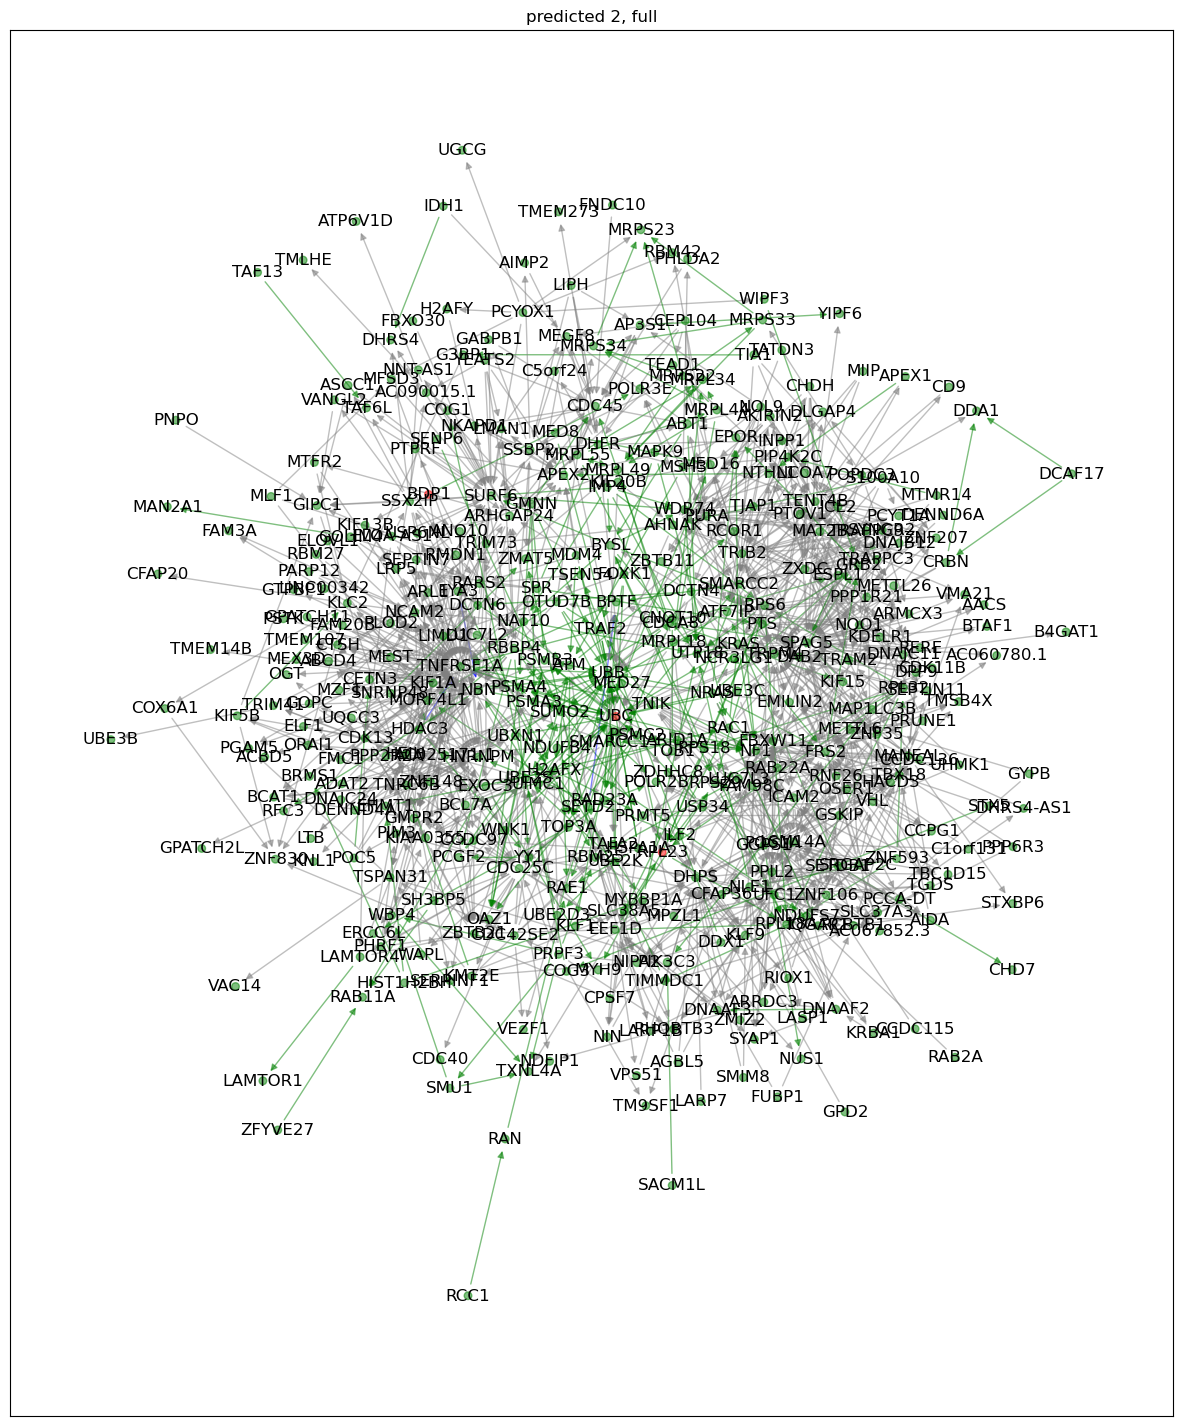

In [1234]:

G = nx.from_numpy_array(Adj.values.astype('bool'))
labeldict = dict(zip([i for i in range(len(Adj.index))], Adj.index))
G = nx.relabel_nodes(G, labeldict)

components = sorted(nx.connected_components(G), key=len, reverse=True)
components = [comp for comp in components if len(comp) > 1]
components = set().union(*components)

G = G.subgraph(components)
col_di = {0:'grey',1:'grey', 2:'blue', -1: 'green'}
edge_colors = [col_di[Adj.loc[edge[0], edge[1]]] for edge in nx.edges(G)]
draw_graph(G, ['RPL23', 'BDP1','UBC', 'MPRL34'], edge_colors=edge_colors)
plt.title('predicted 2, full')


Text(0.5, 1.0, 'predicted 2, substracted')

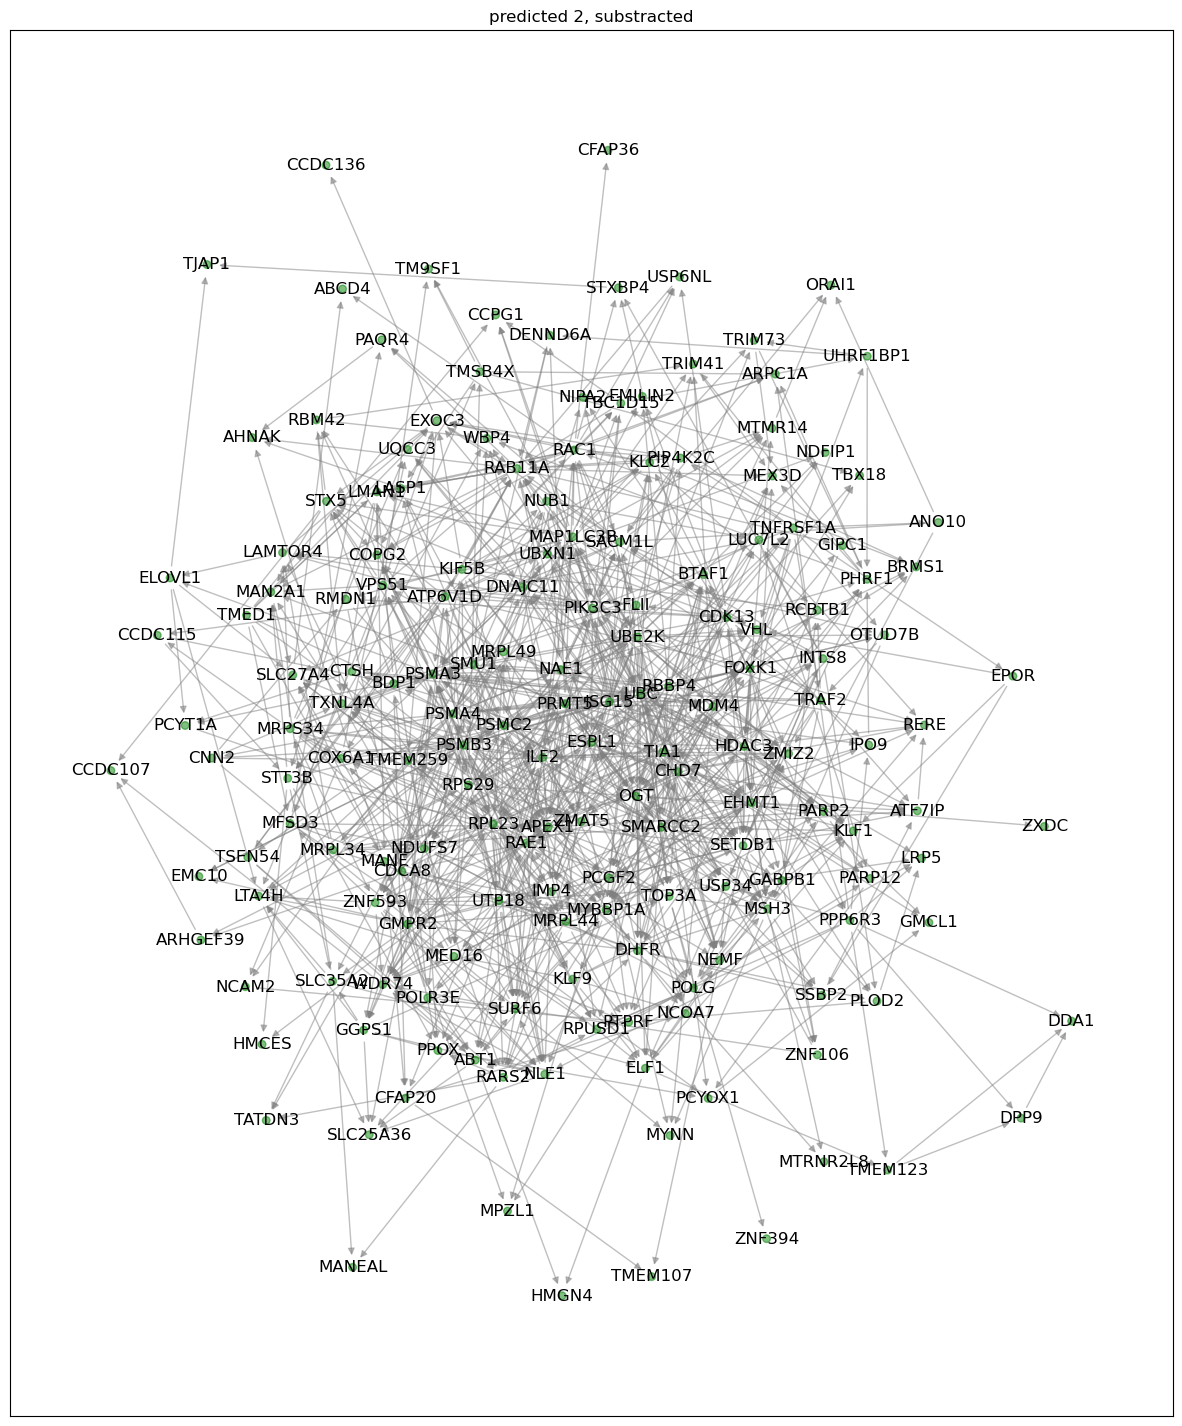

In [676]:
#nth_comb_score = np.sort(protein_links['combined_score'])#[-n]
cond1 = (protein_links['combined_score']>0)
#cond2 = (protein_links['discovered'] > 0)
sub_df = protein_links[cond1]

edges = sub_df[['protein1', 'protein2']].values.tolist()
string_graph = nx.from_edgelist(edges)
string_Adj = nx.adjacency_matrix(string_graph)

draw_graph(string_graph)
plt.title('predicted 2, substracted')

In [2452]:
len(protein_links)

2054

In [2239]:
len(sub_df)

100

(array([44., 23.,  9.,  6.,  3.,  1.,  2.,  1.,  0.,  1.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

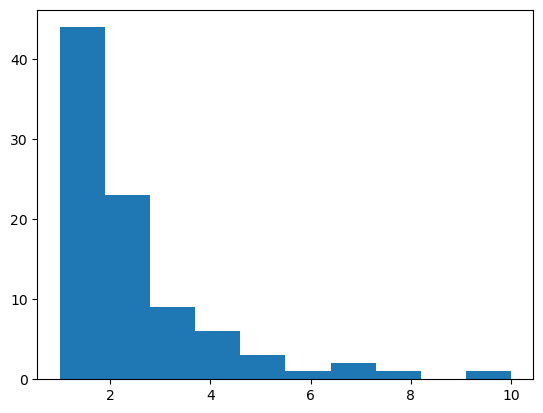

In [1320]:
string_Adj = nx.adjacency_matrix(string_graph)
plt.hist(string_Adj.sum(1))

In [1220]:
max(Adj.sum(0))

7

(array([ 8., 24., 10., 31., 20., 36., 37., 13., 19.,  2.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

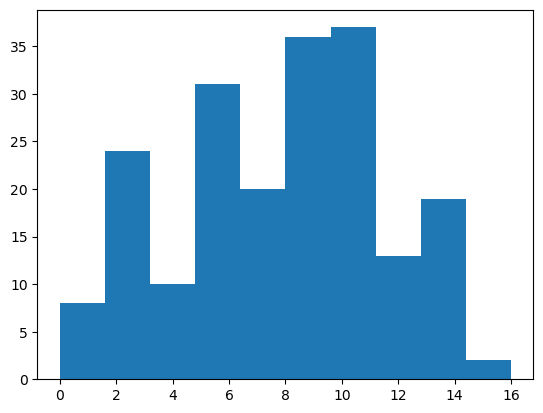

In [677]:
plt.hist((Adj>0).sum(1))
#plt.xlim(1, 21)


In [919]:
max(Adj.sum(1))

38

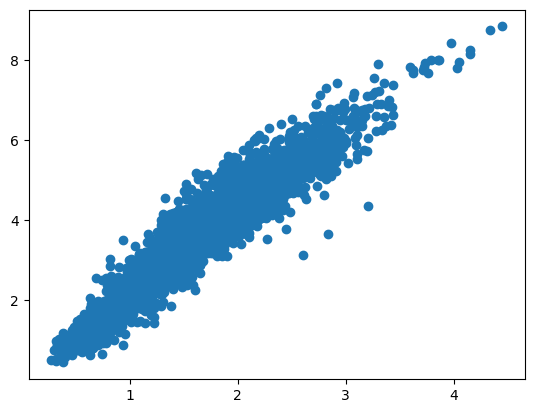

In [164]:
plt.scatter(data.adata.X[:, data.adata.var.gene_name == 'BDP1'].squeeze(1),
           data.adata.X[:, data.adata.var.gene_name == 'LUC7L2'].squeeze(1))






In [256]:
from torch.distributions import NegativeBinomial, Normal


class ModelMDN(pl.LightningModule):
    def __init__(self, genes, n_genes_in_minibatch, 
                     embed_size=10, lr=0.001, perc_hidden=0.25, wd=0.01):
        super().__init__()
        self.genes = genes
        self.n_genes = len(self.genes)
        self.n_genes_in_minibatch = n_genes_in_minibatch
        self.embed_size = embed_size
        self.lr = lr
        self.wd = wd
        self.perc_hidden = perc_hidden
        self.calculate_attention = True
        
        self.act = nn.ReLU()
        self.embedding = nn.Embedding(self.n_genes, self.embed_size)
        self.attn = BinaryAttention(self.embed_size, function='softmax')
        self.ll0 = nn.Linear(self.embed_size+1, self.embed_size+1)
        self.ll1 = nn.Linear(self.embed_size + 1, self.embed_size+1)
        self.bn_attn1 = nn.BatchNorm1d(self.embed_size + 1)
        self.bn1 = nn.BatchNorm1d(self.embed_size + 1)
        self.bn_attn2 = nn.BatchNorm1d(self.embed_size + 1)
        self.ll2 = nn.Linear(self.embed_size + 1, self.embed_size + 1)
        self.bn2 = nn.BatchNorm1d(self.embed_size + 1)
        self.ll3 = nn.Linear((self.embed_size + 1), (self.embed_size + 1))
        self.ll4 = nn.Linear((self.embed_size + 1), 2)
        
        self.model = nn.ModuleList(
                             [self.embedding, self.attn, self.bn_attn1,
                             self.ll1, self.bn1,
                             self.bn_attn2, self.ll2, self.bn2,
                             self.ll3, self.ll4]
                    )
        
        self.loss_fn = nn.MSELoss()
        self.save_hyperparameters(logger=False)
        
    def add_precomputed_attention(self, attention):
        genes_with_no_links = set(self.genes) - set(attention.index)
        attention.loc[:, genes_with_no_links] = 0
        
        attention = attention.T
        attention.loc[:, genes_with_no_links] = 0
        attention = attention.T
        
        attention = attention.loc[self.genes].loc[:, self.genes]
        self.precomputed_attention = torch.tensor(attention.values, requires_grad=False, dtype=torch.double)
        self.calculate_attention = False
        
    def forward(self, x, gene_idxs):

        x_emb = self.embedding(gene_idxs)
        
        x_emb = self.act(x_emb)

        if self.calculate_attention:
            attn_weights = self.attn(x_emb, x_emb)
        else:
            attn_weights = self.precomputed_attention[gene_idxs][:, gene_idxs]
        
        x_emb = x_emb[None, :, :].repeat((x.shape[0], 1, 1))
        x = x[:, :, None]
        x = torch.concat((x, x_emb), 2)
        
        x = self.ll0(x)
        
        attn_output1 = torch.einsum('bjk, lj -> blk', x, attn_weights)
        attn_output1 = self.act(attn_output1)
        attn_output1 = attn_output1.permute(0, 2, 1)
        attn_output1 = self.bn_attn1(attn_output1)
        attn_output1 = attn_output1.permute(0, 2, 1)

        ll_output1 = self.ll1(attn_output1)
        ll_output1 = self.act(ll_output1)
        ll_output1 = ll_output1.permute(0, 2, 1)
        ll_output1 = self.bn1(ll_output1)
        ll_output1 = ll_output1.permute(0, 2, 1)

        attn_output2 = torch.einsum('bjk, lj -> blk', ll_output1, attn_weights)
        attn_output2 = self.act(attn_output2)
        attn_output2 = attn_output2.permute(0, 2, 1)
        attn_output2 = self.bn_attn2(attn_output2)
        attn_output2 = attn_output2.permute(0, 2, 1)

        ll_output2 = self.ll2(attn_output2)
        ll_output2 = self.act(ll_output2)
        ll_output2 = ll_output2.permute(0, 2, 1)
        ll_output2 = self.bn2(ll_output2)
        ll_output2 = ll_output2.permute(0, 2, 1)
        
        # combined = torch.concat((ll_output1, ll_output2), axis=2)
        combined = torch.max(torch.concat((ll_output1[:, :, :, None], ll_output2[:, :, :, None]), 3), 3)[0]

        res = self.ll3(combined)
        res = self.act(res)
        res = self.ll4(res)
        #res = res.squeeze(2)

        res = torch.concat((torch.abs(res[:, :, 0][:, :, None]), 
                                torch.abs(res[:, :, 1])[:, :, None]), axis=2)
        
        return res
        
    def training_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('train_loss', loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('val_loss', loss)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('test_loss', loss)
        return loss
    
    def _common_step(self, batch, batch_idx):
        x = batch.float()
        if not self.calculate_attention:
            self.precomputed_attention = self.precomputed_attention.to(self.device).float()
        
        gene_mask = self._generate_random_mask(self.n_genes, self.n_genes_in_minibatch)
        gene_idxs = torch.where(gene_mask)[0]
        x = x[:, gene_mask]

        preds = self.forward(x, gene_idxs)

        loss = self.normal_loss(x, preds)
        
        return loss, preds, x
    
    def nb_loss(self, x, pred_params):
        loss = 0
        for i in range(x.shape[1]):
            dist = NegativeBinomial(pred_params[:, i, 0], logits=pred_params[:, i, 1])
            loss += torch.mean(dist.log_prob(x[:, i]))
        loss = -loss / x.shape[1]
        return loss
    
    def normal_loss(self, x, pred_params):
        loss = 0
        
        for i in range(x.shape[1]):
            dist = Normal(pred_params[:, i, 0], pred_params[:, i, 1])
            loss += torch.mean(dist.log_prob(x[:, i]))
        loss = -loss / x.shape[1]
        return loss
    
    def predict_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        
        return scores, y
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.wd)
    
    def _generate_random_mask(self, total_size, sample_size):
        mask = torch.full((total_size,), False, dtype=bool)
        mask[:sample_size] = True
        mask = mask[torch.randperm(total_size)].to(self.device)
        return mask
    
    def calculate_attention_matrix(self):
        x_emb = self.embedding(torch.arange(self.n_genes).to(self.device))
        #x_emb = x_emb[None, :, :].repeat((self.n_genes, 1, 1))
        self.attention_matrix = self.attn(x_emb, x_emb)
        self.attention_matrix = self.attention_matrix.detach().cpu().numpy()
        

## Experiment with implementing attention

In [ ]:
class ExperimentalModel(pl.LightningModule):
    def __init__(self, genes, n_genes_in_minibatch, 
                     embed_size=10, lr=0.001, perc_hidden=0.25, wd=0.01):
        super().__init__()
        self.genes = genes
        self.n_genes = len(self.genes)
        self.n_genes_in_minibatch = n_genes_in_minibatch
        self.embed_size = embed_size
        self.lr = lr
        self.wd = wd
        self.perc_hidden = perc_hidden
        self.calculate_attention = True
        
        self.act = nn.ReLU()
        self.embedding = nn.Embedding(self.n_genes, embed_size)
        self.attn = nn.MultiheadAttention(self.embed_size, 1, batch_first=True)
        self.ll1 = nn.Linear(self.embed_size + 1, 11)
        self.bn_attn1 = nn.BatchNorm1d(self.embed_size + 1)
        self.bn1 = nn.BatchNorm1d(self.embed_size + 1)
        self.bn_attn2 = nn.BatchNorm1d(self.embed_size + 1)
        self.ll2 = nn.Linear(self.embed_size + 1, self.embed_size + 1)
        self.bn2 = nn.BatchNorm1d(self.embed_size + 1)
        self.ll3 = nn.Linear((self.embed_size + 1) * 2, 1)
        
        self.model = nn.ModuleList(
                             [self.embedding, self.attn, self.bn_attn1,
                             self.ll1, self.bn1,
                             self.bn_attn2, self.ll2, self.bn2,
                             self.ll3]
                    )
        
        self.loss_fn = nn.MSELoss()
        
        self.att_computed = False
        

        
        
        self.save_hyperparameters(logger=False)
        
    def add_precomputed_attention(self, attention):
        genes_with_no_links = set(self.genes) - set(attention.index)
        attention.loc[:, genes_with_no_links] = 0
        
        attention = attention.T
        attention.loc[:, genes_with_no_links] = 0
        attention = attention.T
        
        attention = attention.loc[self.genes].loc[:, self.genes]
        self.precomputed_attention = torch.tensor(attention.values, requires_grad=False, dtype=torch.double)
        self.calculate_attention = False
        
    def forward(self, x, gene_idxs, hidden_idxs):

        x_emb = self.embedding(gene_idxs)

        if self.calculate_attention:
            _, attn_weights = self.attn(x_emb, x_emb, x_emb)
            diag_idxs = torch.arange(attn_weights.shape[0])
            attn_weights[diag_idxs, diag_idxs] = 0
            attn_weights[:, hidden_idxs] = 0
            
            #attn_weights = (attn_weights > 0.005).to(torch.float32)
        else:
            attn_weights = self.precomputed_attention[gene_idxs][:, gene_idxs]
        
        self.att = attn_weights
        self.att_computed=True
        
        x_emb = x_emb[None, :, :].repeat((x.shape[0], 1, 1))
        x = x[:, :, None]
        x = torch.concat((x, x_emb), 2)
        
            
        attn_output1 = torch.einsum('bjk, lj -> blk', x, attn_weights)
        attn_output1 = self.act(attn_output1)
        attn_output1 = attn_output1.permute(0, 2, 1)
        attn_output1 = self.bn_attn1(attn_output1)
        attn_output1 = attn_output1.permute(0, 2, 1)

        ll_output1 = self.ll1(attn_output1)
        ll_output1 = self.act(ll_output1)
        ll_output1 = ll_output1.permute(0, 2, 1)
        ll_output1 = self.bn1(ll_output1)
        ll_output1 = ll_output1.permute(0, 2, 1)

        attn_output2 = torch.einsum('bjk, lj -> blk', ll_output1, attn_weights)
        attn_output2 = self.act(attn_output2)
        attn_output2 = attn_output2.permute(0, 2, 1)
        attn_output2 = self.bn_attn2(attn_output2)
        attn_output2 = attn_output2.permute(0, 2, 1)

        ll_output2 = self.ll2(attn_output2)
        ll_output2 = self.act(ll_output2)
        ll_output2 = ll_output2.permute(0, 2, 1)
        ll_output2 = self.bn2(ll_output2)
        ll_output2 = ll_output2.permute(0, 2, 1)

        combined = torch.concat((ll_output1, ll_output2), axis=2)
        res = self.ll3(combined)

        res = res.squeeze(2)
        
        return res, attn_weights
        
    def training_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('train_loss', loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('val_loss', loss)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('test_loss', loss)
        return loss
    
    def _common_step(self, batch, batch_idx):
        x = batch 
        if not self.calculate_attention:
            self.precomputed_attention = self.precomputed_attention.to(self.device).float()
        
        gene_idxs = self._generate_random_mask(self.n_genes, self.n_genes_in_minibatch)
        x = x[:, gene_idxs]

#         if self.att_computed:
#             n = 1000
#             nth_val = torch.sort(torch.flatten(self.att))[0][-n]
#             degrees = torch.sum(self.att > nth_val, axis=1).float()
#             hidden_weights = torch.softmax(degrees, 0)
#         else:
#             hidden_weights = None
        
        hidden_idxs = self._generate_random_mask(self.n_genes_in_minibatch, 
                                    int(self.n_genes_in_minibatch * self.perc_hidden))
#         hidden_idxs_mask = self._generate_random_mask(self.n_genes_in_minibatch, 
#                                     int(self.n_genes_in_minibatch * self.perc_hidden), hidden_weights)
#         hidden_idxs = torch.concat((hidden_idxs_test, hidden_idxs_mask))
        
        x_corrupted = torch.clone(x)
        x_corrupted[:, hidden_idxs] = -1.
        
        preds, attn_weights = self.forward(x_corrupted, gene_idxs, hidden_idxs)

        loss = self.loss_fn(preds[:, hidden_idxs], 
                            x[:, hidden_idxs])
            
        #loss += torch.sum(attn_weights) * 1e-2
        #n = 1000
        #nth_val = torch.sort(torch.flatten(attn_weights))[0][-n]
        #degrees = torch.sum(attn_weights>nth_val, axis=0)
        #loss += (torch.max(degrees) - 5) * 0.05
            
        return loss, preds, x
    
    def predict_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        
        return scores, y
    
    def configure_optimizers(self):
        non_frozen_parameters = [p for p in self.parameters() if p.requires_grad]
        return torch.optim.AdamW(non_frozen_parameters, lr=self.lr, weight_decay=self.wd)
    
    def _generate_random_mask(self, total_size, sample_size, weights=None):
        #mask = torch.full((total_size,), False, dtype=bool)
        #mask[:sample_size] = True
        
        if weights is not None:
            weights = weights.cpu().detach().numpy()
        
        mask = np.random.choice(np.arange(total_size), sample_size, replace=False, p=weights)
        
        mask = torch.tensor(mask).to(self.device)
        return mask
    
    def calculate_attention_matrix(self):
        x_emb = self.embedding(torch.arange(self.n_genes).to(self.device))
        #x_emb = x_emb[None, :, :].repeat((self.n_genes, 1, 1))
        self.attention_matrix = self.attn(x_emb, x_emb, x_emb)[1]
        self.attention_matrix = self.attention_matrix.detach().cpu().numpy()
        
    def add_weights(self, path):
        with torch.no_grad():
            state_dict = torch.load(path)['state_dict']

            #self.embedding.weight.copy_(state_dict['embedding.weight'])
            
            self.ll1.weight.copy_(state_dict['ll1.weight'])
            self.ll1.bias.copy_(state_dict['ll1.bias'])

            self.ll2.weight.copy_(state_dict['ll2.weight'])
            self.ll2.bias.copy_(state_dict['ll2.bias'])

            self.ll3.weight.copy_(state_dict['ll3.weight'])
            self.ll3.bias.copy_(state_dict['ll3.bias'])

            self.bn_attn1.weight.copy_(state_dict['bn_attn1.weight'])
            self.bn_attn1.bias.copy_(state_dict['bn_attn1.bias'])

            self.bn_attn2.weight.copy_(state_dict['bn_attn2.weight'])
            self.bn_attn2.bias.copy_(state_dict['bn_attn2.bias'])

            self.bn1.weight.copy_(state_dict['bn1.weight'])
            self.bn1.bias.copy_(state_dict['bn1.bias'])

            self.bn2.weight.copy_(state_dict['bn2.weight'])
            self.bn2.bias.copy_(state_dict['bn2.bias'])
        
        for name, parameter in self.named_parameters():
            if name.split('.')[0] in ['ll1', 'll2', 'll3',
                                     'bn_attn1', 'bn_attn2',
                                     'bn1', 'bn2']:
                parameter.requires_grad = False

                
                
                

In [ ]:
N_SAMPLE_GENES = 200
LR = 0.0001
PERC_HIDDEN = 0.25

model = ExperimentalModel(data.genes, N_SAMPLE_GENES, lr=LR, perc_hidden=PERC_HIDDEN)
ckpt_dir = '/home/artemy/causal_proj/data/models/start/att_MDN/'

model.add_weights(f'{ckpt_dir}epoch=99-step=28200-v2.ckpt')





wandb.finish()
wandb_logger = WandbLogger(name='att, no self-embed, pert=0.25, sample proportionally to degree dist, binary, separate hiddens', project='causal_dev_experiment_with_attention, T')




ACCELERATOR = 'gpu'
DEVICES = [0]
NUM_EPOCHS = 100


torch.set_float32_matmul_precision('medium')


trainer = pl.Trainer(
        #logger=wandb_logger,
        accelerator=ACCELERATOR,
        devices=DEVICES,
        min_epochs=1,
        max_epochs=NUM_EPOCHS,
        #callbacks = [EvaluatorCallback(ToyEvaluator(data))],
    )

trainer.fit(model, data)

In [ ]:
class Model(pl.LightningModule):
    def __init__(self, genes, n_genes_in_minibatch, 
                     embed_size=100, lr=0.001, perc_hidden=0.25, wd=0.01):
        super().__init__()
        self.genes = genes
        self.n_genes = len(self.genes)
        self.n_genes_in_minibatch = n_genes_in_minibatch
        self.embed_size = embed_size
        self.lr = lr
        self.wd = wd
        self.perc_hidden = perc_hidden
        self.calculate_attention = True
        
        self.act = nn.ReLU()
        self.embedding = nn.Embedding(self.n_genes, embed_size)
        self.ll0 = nn.Linear(self.embed_size+1, self.embed_size+1)
        self.attn = BinaryAttention(self.embed_size, function='softmax_t')
        self.ll1 = nn.Linear(self.embed_size+1, self.embed_size)
        self.bn_attn1 = nn.BatchNorm1d(self.embed_size+1)
        self.bn1 = nn.BatchNorm1d(self.embed_size)
        self.bn_attn2 = nn.BatchNorm1d(self.embed_size)
        self.ll2 = nn.Linear(self.embed_size, self.embed_size)
        self.bn2 = nn.BatchNorm1d(self.embed_size)
        
#         self.bn_attn3 = nn.BatchNorm1d(self.embed_size)
#         self.ll3 = nn.Linear(self.embed_size, self.embed_size)
#         self.bn3 = nn.BatchNorm1d(self.embed_size)
        self.ll_prefin = nn.Linear(self.embed_size, self.embed_size)
        self.ll_fin = nn.Linear(self.embed_size, 1)
        
        self.model = nn.ModuleList(
                             [self.embedding, self.attn, self.bn_attn1,
                             self.ll1, self.bn1,
                             self.bn_attn2, self.ll2, self.bn2,
                            self.ll_prefin,
                             self.ll_fin]
                    )
        
        self.loss_fn = nn.MSELoss()
        self.save_hyperparameters(logger=False)
        
    def add_precomputed_attention(self, attention):
        genes_with_no_links = set(self.genes) - set(attention.index)
        attention.loc[:, genes_with_no_links] = 0
        
        attention = attention.T
        attention.loc[:, genes_with_no_links] = 0
        attention = attention.T
        
        attention = attention.loc[self.genes].loc[:, self.genes]
        self.precomputed_attention = torch.tensor(attention.values, requires_grad=False, dtype=torch.double)
        self.calculate_attention = False
        
    def forward(self, x, gene_idxs, hidden_idxs):

        x_emb = self.embedding(gene_idxs)
        
        #x_emb = self.act(x_emb)

        if self.calculate_attention:
            attn_weights = self.attn(x_emb, x_emb, hidden_idxs)
            
        else:
            attn_weights = self.precomputed_attention[gene_idxs][:, gene_idxs]
            
        x_emb = x_emb[None, :, :].repeat((x.shape[0], 1, 1))
        x = x[:, :, None]
        x = torch.concat((x, x_emb), 2)
        
        x = self.ll0(x)
        
        attn_output1 = torch.einsum('bjk, lj -> blk', x, attn_weights)
        attn_output1 = self.act(attn_output1)
        attn_output1 = attn_output1.permute(0, 2, 1)
        attn_output1 = self.bn_attn1(attn_output1)
        attn_output1 = attn_output1.permute(0, 2, 1)

        ll_output1 = self.ll1(attn_output1)
        ll_output1 = self.act(ll_output1)
        ll_output1 = ll_output1.permute(0, 2, 1)
        ll_output1 = self.bn1(ll_output1)
        ll_output1 = ll_output1.permute(0, 2, 1)

        attn_output2 = torch.einsum('bjk, lj -> blk', ll_output1, attn_weights)
        attn_output2 = self.act(attn_output2)
        attn_output2 = attn_output2.permute(0, 2, 1)
        attn_output2 = self.bn_attn2(attn_output2)
        attn_output2 = attn_output2.permute(0, 2, 1)

        ll_output2 = self.ll2(attn_output2)
        ll_output2 = self.act(ll_output2)
        ll_output2 = ll_output2.permute(0, 2, 1)
        ll_output2 = self.bn2(ll_output2)
        ll_output2 = ll_output2.permute(0, 2, 1)
        
#         attn_output3 = torch.einsum('bjk, lj -> blk', ll_output2, attn_weights)
#         attn_output3 = self.act(attn_output3)
#         attn_output3 = attn_output3.permute(0, 2, 1)
#         attn_output3 = self.bn_attn3(attn_output3)
#         attn_output3 = attn_output3.permute(0, 2, 1)
        
#         ll_output3 = self.ll3(attn_output3)
#         ll_output3 = self.act(ll_output3)
#         ll_output3 = ll_output3.permute(0, 2, 1)
#         ll_output3 = self.bn3(ll_output3)
#         ll_output3 = ll_output3.permute(0, 2, 1)
        
        #combined = torch.concat((ll_output1, ll_output2), axis=2)
        #combined = torch.max(torch.concat((ll_output1[:, :, :, None], ll_output2[:, :, :, None]), 3), 3)[0]
        combined = ll_output2
        #combined = torch.concat((x_emb, combined), axis=2)
        
        #combined = ll_output1 + ll_output2
        #combined = self.ll_prefin(combined)
        #combined = self.act(combined)
        
        res = self.ll_fin(combined)
        res = res.squeeze(2)
        
        return res, attn_weights
        
    def training_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('train_loss', loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('val_loss', loss)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('test_loss', loss)
        return loss
    
    def _common_step(self, batch, batch_idx):
        x = batch.float()
        if not self.calculate_attention:
            self.precomputed_attention = self.precomputed_attention.to(self.device).float()
        
        gene_mask = self._generate_random_mask(self.n_genes, self.n_genes_in_minibatch)
        gene_idxs = torch.where(gene_mask)[0]
        x = x[:, gene_mask]

#         if model.global_step % 5 == 0:
        self.hidden_mask = self._generate_random_mask(self.n_genes_in_minibatch, 
                                    int(self.n_genes_in_minibatch * self.perc_hidden))
        self.hidden_idxs = torch.where(self.hidden_mask)[0]
            
        x_corrupted = torch.clone(x)
        x_corrupted[:, self.hidden_mask] = 0.
        
        preds, attn_weights = self.forward(x_corrupted, gene_idxs, self.hidden_idxs)
        if not self.calculate_attention:
            loss = self.loss_fn(preds[:, self.hidden_mask & (self.precomputed_attention.sum(0)!=0)], 
                                x[:, self.hidden_mask & (self.precomputed_attention.sum(0)!=0)])
        else:
#             loss = self.loss_fn(preds[:, self.hidden_mask], 
#                                 x[:, self.hidden_mask])
            
             loss = self.loss_fn(preds, 
                                 x)
            
        return loss, preds, x
    
    def predict_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        
        return scores, y
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.wd)
    
    def _generate_random_mask(self, total_size, sample_size):
        mask = torch.full((total_size,), False, dtype=bool)
        mask[:sample_size] = True
        mask = mask[torch.randperm(total_size)].to(self.device)
        return mask
    
    def calculate_attention_matrix(self):
        x_emb = self.embedding(torch.arange(self.n_genes).to(self.device))
        self.attention_matrix = self.attn(x_emb, x_emb)
        self.attention_matrix = self.attention_matrix.detach().cpu().numpy()
        